# Exercícios: Modelos avançados para processamento de linguagem natural 
Fonte: CARVALHO, Fabrício Galende Marques de. **Notas de aula da disciplina de processamento de linguagem natural.** São José dos Campos, 2023.

## Prática de programação
---

1. (PP.4.1) Construa um modelo do tipo word2vec (W2V) para classificação de revisões de produto que atenda aos seguintes critérios:
    - O modelo deve operar sobre dados de revisão que tenham sido pré-processados;
    - O modelo deve ser comparado, em termos de desempenho de classificação, com um modelo clássico do tipo bag of words (BOW) com transformação TFIDF.
    - Para a classificação, utilizar no mínimo 15 reviews de treinamento, classificador utilizando Multilayer Perceptron e mais 45 reviews de validação, sendo elas igualmente distribuídas entre revisões positivas, negativas e neutras.
    
Crie uma tabela comparativa entre o BOW e W2V que mostre o percentual de acerto das reviews e a probabilidade média relacionada aos acertos. 


### Acesso e pré processamento dos dados

In [1]:
import pandas as pd
import spacy
import nltk
import re
import numpy as np
from unidecode import unidecode
from datetime import datetime

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.phrases import Phrases, Phraser
from gensim.models import word2vec

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score

import matplotlib.pyplot as plt
import seaborn as sn

!python -m spacy download pt

⚠ As of spaCy v3.0, shortcuts like 'pt' are deprecated. Please use the
full pipeline package name 'pt_core_news_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 45.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [2]:
# =============================================================================
# Acesso aos dados
# ============================================================================= 
url = 'https://raw.githubusercontent.com/americanas-tech/b2w-reviews01/main/B2W-Reviews01.csv'
df = pd.read_csv(url, sep = ',',low_memory=False)

# =============================================================================
# Análise exploratória e adaptações
# ============================================================================= 
df.rename(columns = {'overall_rating': 'stars','submission_date':'created_at','review_text':'text'}, inplace=True)
df['processed_at'] = datetime.now()
df = df[~df['text'].isna()].reset_index(drop=True)
df = df[df['text'].str.contains("\w")]
df = df[df['text'].str.len() > 3]
df = df.drop_duplicates('text').reset_index(drop=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.drop(columns=[
      'reviewer_id', 
      'product_brand', 
      'site_category_lv1', 
      'site_category_lv2', 
      'review_title',
      'recommend_to_a_friend'])

# =============================================================================
# Selecionando e classificando o sentimento das avaliações
# ============================================================================= 
def random_select(seedNumber, df, sentiment, quantity):
    condition = df['stars'] >= 4 # 4 e 5 "estrelas"
    if(sentiment == 'NEUTRO'):
        condition = df['stars'] == 3 # 3 "estrelas"
    if(sentiment == 'NEGATIVO'):
        condition = df['stars'] <= 2 # 1 e 2 "estrelas"
        
    np.random.seed(seed=seedNumber)
    return np.random.choice(df['text'][condition], quantity, replace=False)

def random_select_sentiment(seedNumber, df, sentiment, quantity):
    condition = df['sentiment'] == sentiment
    np.random.seed(seed=seedNumber)
    return np.random.choice(df['text'][condition], quantity, replace=False)

def select_data(df):
    positive = random_select(100, df, 'POSITIVO', 15)
    neutral = random_select(100, df, 'NEUTRO', 45)
    negative = random_select(100, df, 'NEGATIVO', 20)
    select = np.concatenate([positive, neutral, negative])
    
    df = df[df['text'].isin(select)].reset_index(drop=True)
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df
    
df = select_data(df)

# =============================================================================
# Pré processamento
# ============================================================================= 
nlp = spacy.load("pt_core_news_sm", disable=['parser', 'ner'])
stemmer = nltk.stem.RSLPStemmer()

def remove_stopwords(text):
    # Remove stopwords
    stop_words = [word for word in nlp.Defaults.stop_words]
    stop_words.remove('não') # tirando a palavra "não" das stopwords
    cleaned_text = " ".join([i for i in text if i not in set(stop_words)])
   
    return cleaned_text
    
def clean_text(text):
    # Aplica a remoção de stopwords, caracteres não alfabéticos e outras palavras curtas
    df_corpus = []
    df_c = re.sub('[^A-Za-záàâãéèêíïóôõöúçñÁÀÂÃÉÈÍÏÓÔÕÖÚÇÑ]', ' ', text).lower().split()
    df_corpus.append(df_c)
    df_corpus= pd.Series(df_corpus).apply(lambda x: ' '.join([w for w in x if len(w)>2]))
    corpus = [remove_stopwords(r.split()) for r in df_corpus]  
    
    return corpus
        
def lemmatization(text):
    # Extrai o lema das palavras
    global nlp
    output = []
    
    for sent in text:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc])

    return output
    
def lemmatize(text):
    # Aplica a limpeza do texto e a lemmatização
    token = lemmatization(pd.Series(clean_text(text)).apply(lambda x: x.split()))
    token_lemma = []
    for i in range(len(token)):
        token_lemma.append(' '.join(token[i]))
    
    return token_lemma
    
corpus = []
for review in df['text']:
    result = lemmatize(review)
    corpus.append(result[0])
    
df['corpus'] = corpus
df['sentiment'] = ['POSITIVO','NEGATIVO','POSITIVO','NEGATIVO','NEGATIVO','POSITIVO','NEUTRO','NEGATIVO',
                   'POSITIVO','NEGATIVO','POSITIVO','NEUTRO','NEGATIVO','NEGATIVO','POSITIVO','POSITIVO','POSITIVO',
                   'NEGATIVO','POSITIVO','POSITIVO','POSITIVO','NEGATIVO','POSITIVO','POSITIVO','NEUTRO','NEGATIVO',
                   'NEUTRO','NEUTRO','POSITIVO','NEUTRO','NEUTRO','NEGATIVO','NEGATIVO','POSITIVO','NEUTRO','POSITIVO',
                   'NEUTRO','NEGATIVO','POSITIVO','POSITIVO','POSITIVO','POSITIVO','POSITIVO','POSITIVO','NEUTRO',
                   'NEGATIVO','POSITIVO','NEGATIVO','NEGATIVO','NEUTRO','POSITIVO','POSITIVO','NEGATIVO','POSITIVO',
                   'NEGATIVO','POSITIVO','POSITIVO','NEUTRO','NEGATIVO','POSITIVO','NEUTRO','NEGATIVO','POSITIVO',
                   'POSITIVO','POSITIVO','NEGATIVO','NEGATIVO','POSITIVO','NEUTRO','POSITIVO','POSITIVO','NEUTRO',
                   'NEUTRO','NEUTRO','NEUTRO','POSITIVO','NEGATIVO','POSITIVO','NEUTRO','NEUTRO']

positive = random_select_sentiment(21, df, 'POSITIVO', 20)
neutral = random_select_sentiment(21, df, 'NEUTRO', 20)
negative = random_select_sentiment(21, df, 'NEGATIVO', 20)
select = np.concatenate([positive, neutral, negative])
    
df = df[df['text'].isin(select)].reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)
df['sentiment'].value_counts()

sentiment
NEGATIVO    20
NEUTRO      20
POSITIVO    20
Name: count, dtype: int64

### Bag of Words + TD-IDF

In [3]:
vectorizer = TfidfVectorizer(min_df=0., max_df=1., norm='l2', use_idf=True)

### Word2vec

In [4]:
words = [line.split() for line in corpus]
phrases = Phrases(words, min_count=1, threshold=2, progress_per=1000) 
bigram = Phraser(phrases)
sentences = bigram[words]

w2v_model = word2vec.Word2Vec(min_count=1,epochs = 50)

w2v_model.build_vocab(sentences, progress_per=100)

### Treinamentos

In [5]:
def separate_training_and_testing_data(df):
    # Organização dos dados de treino e teste para inserir no algoritmo
    positive_reviews = []
    neutral_reviews = []
    negative_reviews = []

    for classified_review in df:
        if classified_review['sentiment'] == 'POSITIVO':
            positive_reviews.append(classified_review)
        if classified_review['sentiment'] == 'NEUTRO':
            neutral_reviews.append(classified_review)
        if classified_review['sentiment'] == 'NEGATIVO':
            negative_reviews.append(classified_review)

    positive_training = positive_reviews[:5]
    neutral_training = neutral_reviews[:5]
    negative_training = negative_reviews[:5]

    print('-----------------------------------------------------------------------------')
    print('POSITIVO:', len(positive_reviews),'| Treino:', len(positive_training),'| Teste:', len(positive_reviews[5:]))
    print('NEUTRO:', len(neutral_reviews),'  | Treino:', len(neutral_training),'| Teste:', len(neutral_reviews[5:]))
    print('NEGATIVO:', len(negative_reviews),'| Treino:', len(negative_training),'| Teste:', len(negative_reviews[5:]))
    print('-----------------------------------------------------------------------------')

    training_data = positive_training + neutral_training + negative_training
    testing_data = positive_reviews[5:] + neutral_reviews[5:] + negative_reviews[5:]

    return {'testing_data': testing_data,'training_data': training_data}

comparison_data = separate_training_and_testing_data(df.to_dict("records"))
train_data = pd.DataFrame(comparison_data['training_data'])
test_data = pd.DataFrame(comparison_data['testing_data'])

# =============================================================================
# Word2Vec
# =============================================================================

doc_embeddings_train = []
for row in train_data.iterrows():
    sentence = row[1]['corpus'].split()
    result = []
    for word in sentence:
        result.append(w2v_model.wv[word])
    result = np.mean(np.array(result),axis=0)
    doc_embeddings_train.append(result)

w2v_train_df = pd.DataFrame(np.array(doc_embeddings_train))

doc_embeddings_test = []
for row in test_data.iterrows():
    sentence = row[1]['corpus'].split()
    result = []
    for word in sentence:
        try:
            result.append(w2v_model.wv[word])
        except:
            1
    result = np.mean(np.array(result),axis=0)
    doc_embeddings_test.append(result)
    
w2v_test_df = pd.DataFrame(np.array(doc_embeddings_test))

# =============================================================================
# Bag of Words
# =============================================================================

bow_train_df = pd.DataFrame(vectorizer.fit_transform(train_data['corpus']).todense(), columns=vectorizer.get_feature_names_out())
bow_test_df = pd.DataFrame(vectorizer.transform(test_data['corpus']).todense(), columns=vectorizer.get_feature_names_out())

-----------------------------------------------------------------------------
POSITIVO: 20 | Treino: 5 | Teste: 15
NEUTRO: 20   | Treino: 5 | Teste: 15
NEGATIVO: 20 | Treino: 5 | Teste: 15
-----------------------------------------------------------------------------


### Comparação entre os treinamentos

-----------------------------------------------------------------------------
Matriz de confusão - Bag of Words


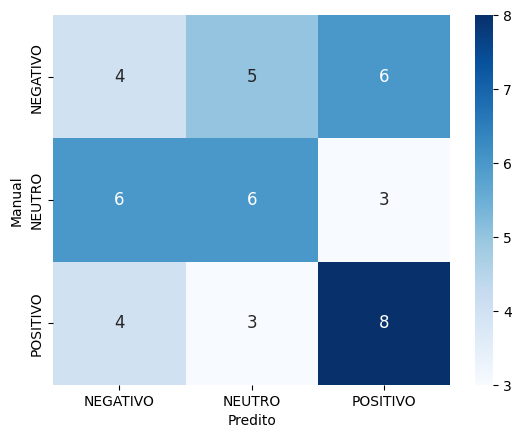

In [6]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 50, 10), random_state=7, max_iter=10000)

y_train = train_data.iloc[:, -1]
y_test = test_data.iloc[:, -1]

all_scores = []

# =============================================================================
# Bag of Words
# =============================================================================
mlp.fit(bow_train_df, y_train)
bow_predict = mlp.predict(bow_test_df)
bow_acc_test_score = accuracy_score(y_test, bow_predict)
bow_pre_test_score = precision_score(y_test, bow_predict, average='weighted')
    
print('-----------------------------------------------------------------------------')
print('Matriz de confusão - Bag of Words')
data = {'Manual': y_test, 'Predito': bow_predict}
df_matrix = pd.DataFrame(data, columns=['Manual','Predito'])
conf = pd.crosstab(df_matrix['Manual'], df_matrix['Predito'], rownames=['Manual'], colnames=['Predito'])
sn.heatmap(conf, annot=True, annot_kws={"size":12}, cmap=plt.cm.Blues)
    
all_scores.append(('Multilayer Perceptron', 'Bag of words', bow_acc_test_score, bow_pre_test_score))

-----------------------------------------------------------------------------
Matriz de confusão - Word2Vec


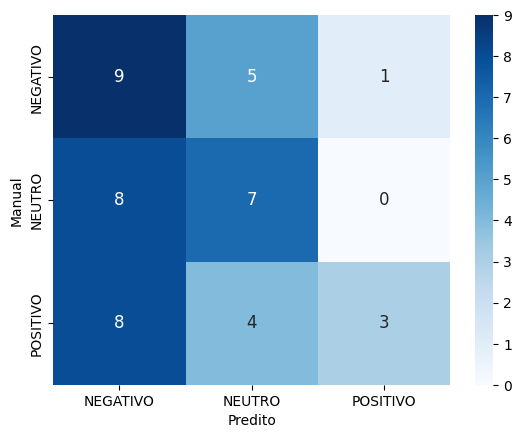

In [7]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 50, 10), random_state=7, max_iter=10000)

# =============================================================================
# Word2Vec
# =============================================================================
mlp.fit(w2v_train_df, y_train)
w2v_predict = mlp.predict(w2v_test_df)
w2v_acc_test_score = accuracy_score(y_test, w2v_predict)
w2v_pre_test_score = precision_score(y_test, w2v_predict, average='weighted')
    
print('-----------------------------------------------------------------------------')
print('Matriz de confusão - Word2Vec')
data = {'Manual': y_test, 'Predito': w2v_predict}
df_matrix = pd.DataFrame(data, columns=['Manual','Predito'])
conf = pd.crosstab(df_matrix['Manual'], df_matrix['Predito'], rownames=['Manual'], colnames=['Predito'])
sn.heatmap(conf, annot=True, annot_kws={"size":12}, cmap=plt.cm.Blues)
    
all_scores.append(('Multilayer Perceptron', 'Word2Vec', w2v_acc_test_score, w2v_pre_test_score))

In [8]:
scores_df = pd.DataFrame(all_scores, columns=['Modelo', 'Embedding', 'Acurácia', 'Precisão'])
scores_df

,Modelo,Embedding,Acurácia,Precisão
0,Multilayer Perceptron,Bag of words,0.400000,0.394958
1,Multilayer Perceptron,Word2Vec,0.422222,0.515833


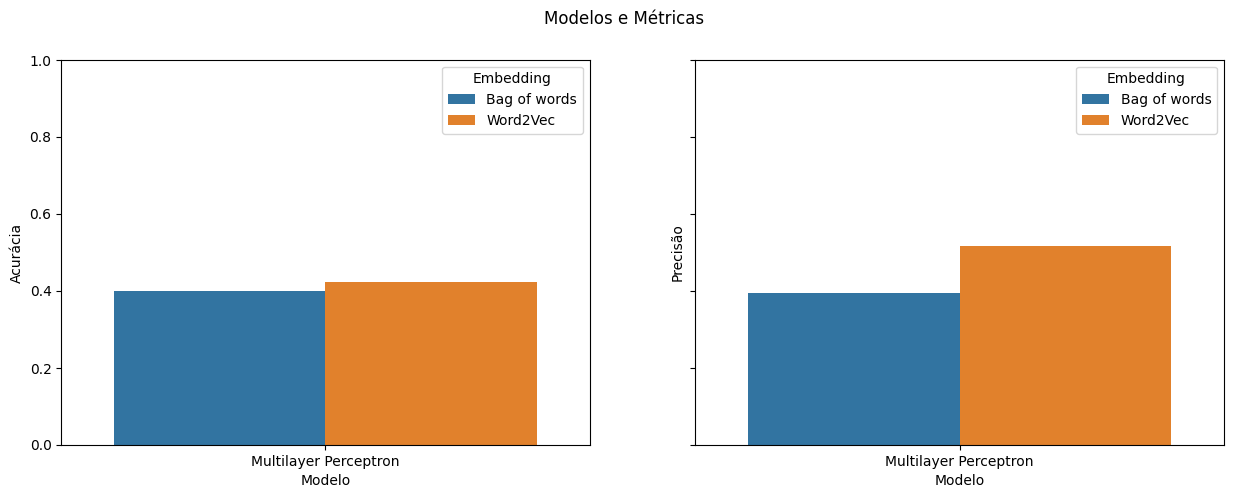

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
plt.ylim([0, 1])

fig.suptitle('Modelos e Métricas')
sns.barplot(ax=axes[0], data=scores_df, x='Modelo', y='Acurácia', hue='Embedding');
sns.barplot(ax=axes[1], data=scores_df, x='Modelo', y='Precisão', hue='Embedding');
print()

2. (PP.4.2) Crie uma aplicação baseada em word2vec que, dada uma frase informada pelo usuário,reescreva essa frase substituindo algumas de suas palavras por sinônimos. Esses sinônimos deverão ser escolhidos utilizando um critério de distância ou ângulo mínimo. Na sua resposta, mostre a base de dados utilizada para treinamento e substituição das palavras e diga se isso afeta ou não o desempenho do sistema. 

In [10]:
# Importando as bibliotecas
import gensim
import re
import pandas as pd
import spacy
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import mac_morpho

# Carregando base de dados
url = 'https://raw.githubusercontent.com/americanas-tech/b2w-reviews01/main/B2W-Reviews01.csv'

data = pd.DataFrame()
data = pd.read_csv(url, sep = ',', encoding='utf-8',low_memory=False)

# Removendo colunas não relevantes
data.rename(columns = {'review_text':'text'}, inplace=True)
data = data[~data['text'].isna()].reset_index(drop=True)
data = data[data['text'].str.contains("\w")]
data = data[data['text'].str.len() > 3]
data = data.drop_duplicates('text').reset_index(drop=True)
data = data.drop(columns=[
      'reviewer_id',
      'product_brand',
      'site_category_lv1',
      'site_category_lv2',
      'review_title',
      'recommend_to_a_friend',
      'overall_rating',
      'product_id',
      'product_name',
      'reviewer_birth_year',
      'reviewer_gender',
      'reviewer_state',
      'submission_date'
      ])

data.head()

,text
0,Estou contente com a compra entrega rápida o ú...
1,"Por apenas R$1994.20,eu consegui comprar esse ..."
2,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4,"A entrega foi no prazo, as americanas estão de..."


In [11]:
# Criando array com sentenças
sentences = []

for sentence in data['text'].values.tolist():
    sentences.append(sentence.split(" "))

print(sentences[0:10])

[['Estou', 'contente', 'com', 'a', 'compra', 'entrega', 'rápida', 'o', 'único', 'problema', 'com', 'as', 'Americanas', 'é', 'se', 'houver', 'troca', 'ou', 'devolução', 'do', 'produto', 'o', 'consumidor', 'tem', 'problemas', 'com', 'espera.'], ['Por', 'apenas', 'R$1994.20,eu', 'consegui', 'comprar', 'esse', 'lindo', 'copo', 'de', 'acrílico.'], ['SUPERA', 'EM', 'AGILIDADE', 'E', 'PRATICIDADE', 'OUTRAS', 'PANELAS', 'ELÉTRICAS.', '', 'COSTUMO', 'USAR', 'OUTRA', 'PANELA', 'PARA', 'COZIMENTO', 'DE', 'ARROZ', '(JAPONESA),', 'MAS', 'LEVA', 'MUITO', 'TEMPO,', '', '+/-', '50', 'MINUTOS.', '', 'NESSA', 'PANELA', '', 'É', 'MUITO', 'MAIS', 'RÁPIDO,', 'EXATAMENTE', '6', 'MINUTOS.', '', '', '', 'EU', 'RECOMENDO.'], ['MEU', 'FILHO', 'AMOU!', 'PARECE', 'DE', 'VERDADE', 'COM', 'TANTOS', 'DETALHES', 'QUE', 'TÊM!'], ['A', 'entrega', 'foi', 'no', 'prazo,', 'as', 'americanas', 'estão', 'de', 'parabéns.', 'A', 'smart', 'tv', 'é', 'muito', 'boa,', 'a', 'navegação', 'na', 'internete', 'e', 'pelos', 'aplicativo

In [12]:
# Limpando sentenças
nlp = spacy.load("pt_core_news_sm", disable=['parser', 'ner'])

def remove_stopwords(text):
    # Remove stopwords
    stop_words = [word for word in nlp.Defaults.stop_words]
    stop_words.remove('não') # tirando a palavra "não" das stopwords
    cleaned_text = " ".join([i for i in text if i not in set(stop_words)])
   
    return cleaned_text

def clean_text(text):
    # Aplica a remoção de stopwords, caracteres não alfabéticos e outras palavras curtas
    df_corpus = []
    df_c = re.sub('[^A-Za-záàâãéèêíïóôõöúçñÁÀÂÃÉÈÍÏÓÔÕÖÚÇÑ]', '', text).lower().split()
    df_corpus.append(df_c)
    df_corpus= pd.Series(df_corpus).apply(lambda x: ' '.join([w for w in x if len(w)>2]))
    corpus = [remove_stopwords(r.split()) for r in df_corpus]  
    
    return corpus

database = []

for sentence in sentences:
    sentences = []
    
    for word in sentence:
        cleaned_word = clean_text(word)[0]
        if cleaned_word != "":
            sentences.append(cleaned_word)
    
    database.append(sentences)
    
print(database[0:10])

[['contente', 'compra', 'entrega', 'rápida', 'único', 'problema', 'americanas', 'houver', 'troca', 'devolução', 'produto', 'consumidor', 'problemas', 'espera'], ['reu', 'consegui', 'comprar', 'lindo', 'copo', 'acrílico'], ['supera', 'agilidade', 'praticidade', 'panelas', 'elétricas', 'costumo', 'panela', 'cozimento', 'arroz', 'japonesa', 'leva', 'minutos', 'panela', 'rápido', 'exatamente', 'minutos', 'recomendo'], ['filho', 'amou', 'verdade', 'tantos', 'detalhes'], ['entrega', 'prazo', 'americanas', 'parabéns', 'smart', 'navegação', 'internete', 'aplicativos', 'excelente', 'não', 'trava', 'falar', 'imagem', 'surpreender', 'recomendo'], ['excelente', 'produto', 'material', 'acrílico', 'super', 'resistente', 'adamantio', 'milagre', 'bebida', 'sugiro', 'aproveitarem', 'promoção', 'acabe'], ['produto', 'mto', 'garrafinha', 'servir', 'água', 'pro', 'megazord', 'pensando', 'vender', 'pra', 'comprar', 'garrafa', 'recomendo'], ['produto', 'excelente', 'qualidade', 'câmera', 'desenvolvimento', 

In [13]:
# Treinamento do modelo
model = gensim.models.Word2Vec(database)

# Salvando o modelo treinado
model.save('mac_morpho_model')
saved_model = gensim.models.Word2Vec.load('mac_morpho_model')

# Retornando as 3 palavras mais similares
saved_model.wv.most_similar(positive = ['ruim'], topn = 3)

[('horrível', 0.8243373036384583),
 ('péssimo', 0.7779094576835632),
 ('fraco', 0.7654045224189758)]

In [14]:
# Criando função para retornar valores mais similares
def transformText(text):
    tranformed_text = saved_model.wv.most_similar(positive = [text], topn = 1)
    return tranformed_text[0][0]

# Substituindo algumas palavras da frase por valores similares
def transformPhrase(phrase):
    tranformed_phrase = ""
    transform_texts = []
    
    for text in phrase.split(" "):
        cleanned_text = clean_text(text)
        
        if cleanned_text[0] == "":
            tranformed_phrase += " " + text
        else:
            transformed_text = transformText(cleanned_text[0])
            tranformed_phrase += " " + transformed_text
            
    print(tranformed_phrase)
    
phrase = "Esse produto é muito bom"

print("Frase original: " + phrase)
transformPhrase(phrase)

Frase original: Esse produto é muito bom
 Esse mercadoria é muito bom
